Advent of Stats
===

Like many of the more fun internet arguments, I've wondered "how hard is Advent of Code, anyway?". Particularly when I've become frustrated at a problem and decided no mere mortal can do it. 
So, what for it but to try some scraping? Let's see how hard each day really is.

Method
---

First, we'll start by scraping the website. I'm not including any scraping, as you will notice the following in the source:

```
Oh, hello!  Funny seeing you here.

...

Please be careful with automated requests; I'm not a massive company, and I can
only take so much traffic.  Please be considerate so that everyone gets to play.

...
```

...I owe you a beer, Eric. For reference, I weight my total downloads at about 15 MB - I'll put the static files on here as well, as a tarball. Naturally you, dear reader, can probably manage to automate the scraping anyway, but it doesn't hurt to not be *careless*. I collected the data on December the 14th 2021 (about the time I tapped out this year, actually...). 

Note, this does induce one important systematic error: if you're like me, and have gone back and solved previous year's puzzles, that can't be distinguished from players solving it live.

First, let's do a little regex (and trying out Python's spangly, controversial walrus operator):

In [9]:
import numpy as np
np.set_printoptions(precision=3)
import re

def completions(year: int):
    """
    grab gold and silver completions for each day in the given year
    """
    with open(f"data/{year}.html") as f:
        lines = f.readlines()
    day = []
    gold = []
    silver = []
    #we're reversing line order to make error handling easier - see later.
    for line in lines[::-1]:
        if c := re.match(r"^.*> *(\d+) .*> *(\d+).*> *(\d+).*$", line):
            #some slightly cheeky error handling here:
            #we'll assume the only reason to find zero gold stars is because the problem hasn't been posted yet.
            #(i.e. we are at the latest day)
            #Luckily, that's the case.
            if int(c[2]) == 0:
                break
            day += [int(c[1])]
            gold += [int(c[2])]
            silver += [int(c[3])]
    return (day, gold, silver)

Now it's a simple method of mapping raw numbers to log:

$$
N = N_0 exp{-\lambda t}
$$

Neat fact: Python's `math` module log is base $e$ by default.

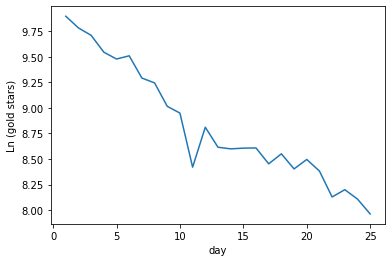

In [10]:
from math import log
import matplotlib.pyplot as plt

(day, gold, silver) = completions(2016)
log_gold = [log(g) for g in gold]
plt.plot(day, log_gold)
plt.xlabel("day")
plt.ylabel("Ln (gold stars)")
plt.show()

Doing the same non-graphically:

In [11]:
import statsmodels.api as sm

def completion_log_fit(year):
    (day, gold, silver) = completions(year)
    #some slightly cheeky error handling here:
    #we'll assume all posted days have a least one star,
    #and therefore, where gold is zero, that's because those days don't exist yet.
    log_gold = [log(g) for g in gold]
    day = sm.add_constant(day)
    model = sm.OLS(log_gold, day)
    results = model.fit()
    return results.params

print(completion_log_fit(2015))

[10.615 -0.093]


In [12]:
for year in (2015, 2016, 2017, 2018, 2019, 2020, 2021):
    print(f"dropout rate for {year} = {-100 * completion_log_fit(year)[1]:.1f} %")

dropout rate for 2015 = 9.3 %
dropout rate for 2016 = 7.5 %
dropout rate for 2017 = 8.0 %
dropout rate for 2018 = 11.9 %
dropout rate for 2019 = 13.1 %
dropout rate for 2020 = 10.2 %
dropout rate for 2021 = 13.5 %


There we go, the hardest complete year is... 2019, losing 13% a day. Although, so far, 2021 may in fact be harder.

At the same time, Advent of Code looks to be becoming more popular! Let's have a look at just how much, using the same exponential fit, but this expecting expect growth instead of decay:

In [13]:
year = (2015, 2016, 2017, 2018, 2019, 2020, 2021)
log_first = [log([g[0] for g in completions(y)][1]) for y in year]
year = sm.add_constant(year)
model = sm.OLS(log_first, year)
results = model.fit()
print(f"growth rate per year = {results.params[1] * 100:.1f} %")

growth rate per year = 29.6 %


30% is *quite* aggressive growth. 2016 is a low outlier. 

We might also be interested in unusually hard days, in a *relative* sense: that is, those that thin out the herd more than would be expected.

visually, hard days are: 

|year  | day |
|------|-----|
| 2015 | 22  |
| 2016 | 11  |
| 2017 | 3   |
| 2018 | 15  |
| 2019 | 18  |
| 2020 | 20  |

I'm leaving 2021 out so far. As it turns out, *all* years have at least one day so hard there are more completions the next (example calculation below):


In [14]:
def hard_days(golds):
    #wait, isn't this day 1 of 2021?
    #exercise for the reader: return which days
    return sum(1 for i in range(len(golds) - 1) if golds[i+1] > golds[i])

print(hard_days(completions(2020)[1]))

4


Additionally, days such as Christmas Eve or Christmas Day do not appear to be outliers.

We could also look at difficulty by the time to first completion; the address for times are a little harder to find:

https://adventofcode.com/{year}/leaderboard/day/{day}
    
Which I've collated into files of the form {year}-{day}.html, then output into times.txt

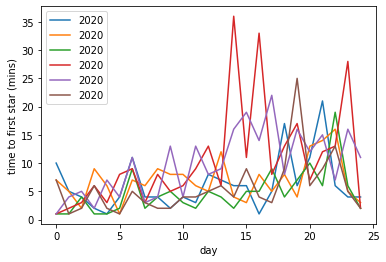

In [15]:
from datetime import datetime

def times(year, day):
    """
    grabs the time of first completion for a given year and day.
    """
    with open(f"data/{year}-{day}.html") as f:
        page = f.read()
    t = re.search(r"1\).*(\d{2}:\d{2}:\d{2})", page)
    d = datetime.strptime(t[1], "%H:%M:%S")
    return (d.minute, d.second)

years = {}
with open("data/times.txt", "w") as f:
    for year in range(2015, 2021):
        days = []
        for day in range(1, 26):
            minute, second = times(year, day)
            days.append(minute)
            f.write(f"{year}, {day}: {minute}, {second}\n")
        years[year] = days

for y in years:
    plt.plot(years[y], label=year)

plt.xlabel("day")
plt.ylabel("time to first star (mins)")
plt.legend()
plt.show()

That file looks... a lot like Aoc input. There are some clear spikes in 2020 days 14 and 16 ("docking data" and "ticket translations", not the CRT theorem day).
Difficulty as determined by "time to first completion" seems to correlate reasonably well with difficulty as determined by dropout rate, at least for 2015.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.694
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                              52.24
Date:                Fri, 04 Feb 2022   Prob (F-statistic):                    2.34e-07
Time:                        14:34:58   Log-Likelihood:                         -17.675
No. Observations:                  24   AIC:                                      37.35
Df Residuals:                      23   BIC:                                      38.53
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

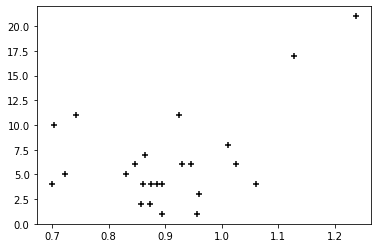

In [16]:
by_time = years[2015][:-1]
by_ratio_data = completions(2015)[1]
by_ratio = [d / e for d, e in zip(by_ratio_data[1:], by_ratio_data[:-1])]
model = sm.OLS(by_ratio, by_time)
results = model.fit()
print(results.summary())
plt.scatter(by_ratio, by_time, marker="+", color="black")
plt.show()